<a href="https://colab.research.google.com/github/bs3537/DS-Unit-1-Sprint-4-Linear-Algebra/blob/master/Dec4_Prelim_FINAL_augmented_IPF_images_plus_normal_CT_Keras_VGG16%2BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

Using TensorFlow backend.


In [0]:
%%capture
import sys


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_data_dir = ('/content/drive/My Drive/Dec 1 2019 keras ipf ct data/Train')
validation_data_dir = ('/content/drive/My Drive/Dec 1 2019 keras ipf ct data/Test')

In [0]:
#Default dimensions of image
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'
# loading up our datasets

#test_data_dir = 'data/test'
 
# number of epochs to train top model 
epochs = 10 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 32

In [0]:
#Loading vgg16 model for feature extraction from image files
from keras import applications
vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

In [15]:
#feature extraction

import datetime
import numpy as np
import math
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(224, 224), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=False) 
 

generator2 = datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(224, 224), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=False) 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
nb_validation_samples = len(generator2.filenames) 
num_classes = len(generator.class_indices)  
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size)) 
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 
bottleneck_features_validation = vgg16.predict_generator(generator2, predict_size_validation) 
np.save('bottleneck_features_train.npy', bottleneck_features_train)
 
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)
end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

Found 651 images belonging to 2 classes.
Found 267 images belonging to 2 classes.
Time:  0:00:08.994283


In [16]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(224, 224), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('bottleneck_features_train.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 651 images belonging to 2 classes.


In [17]:
#validation data

generator_top = datagen.flow_from_directory( 
   validation_data_dir, 
   target_size=(224, 224), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_validation_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
validation_data = np.load('bottleneck_features_validation.npy') 
 
# get the class labels for the training data, in the original order 
validation_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 267 images belonging to 2 classes.


In [0]:
#Neural network Model
start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(75, activation='relu'))
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               5017800   
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 75)                15075     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 152       
Total params: 5,033,027
Trainable params: 5,033,027
Non-trainable params: 0
____________________________________________

In [20]:
#train and validate model
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(train_data, train_labels, 
   epochs=10,
   batch_size=batch_size, 
   validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    validation_data, validation_labels, batch_size=batch_size, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

Train on 651 samples, validate on 267 samples
Epoch 1/10
651/651 [==============================] - 1s 1ms/step - loss: 0.5640 - acc: 0.7481 - val_loss: 0.4224 - val_acc: 0.8240
Epoch 2/10
651/651 [==============================] - 0s 467us/step - loss: 0.2212 - acc: 0.9124 - val_loss: 0.2053 - val_acc: 0.9288
Epoch 3/10
651/651 [==============================] - 0s 434us/step - loss: 0.1257 - acc: 0.9647 - val_loss: 0.4301 - val_acc: 0.8052
Epoch 4/10
651/651 [==============================] - 0s 427us/step - loss: 0.0772 - acc: 0.9754 - val_loss: 0.1349 - val_acc: 0.9288
Epoch 5/10
651/651 [==============================] - 0s 441us/step - loss: 0.0403 - acc: 0.9969 - val_loss: 0.3032 - val_acc: 0.8951
Epoch 6/10
651/651 [==============================] - 0s 429us/step - loss: 0.0348 - acc: 0.9908 - val_loss: 0.1480 - val_acc: 0.9363
Epoch 7/10
651/651 [==============================] - 0s 421us/step - loss: 0.0188 - acc: 0.9954 - val_loss: 0.1128 - val_acc: 0.9513
Epoch 8/10
651/651

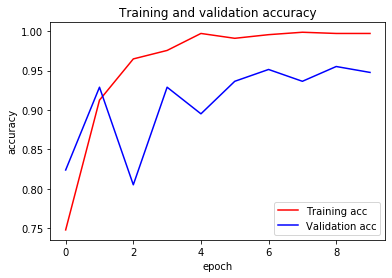

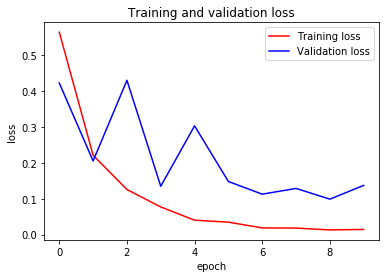

In [21]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.ylabel("accuracy") 
plt.xlabel("epoch")
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.ylabel("loss") 
plt.xlabel("epoch")
plt.legend()
plt.show()